In [154]:
from PIL import Image
import IPython.display

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from datetime import datetime

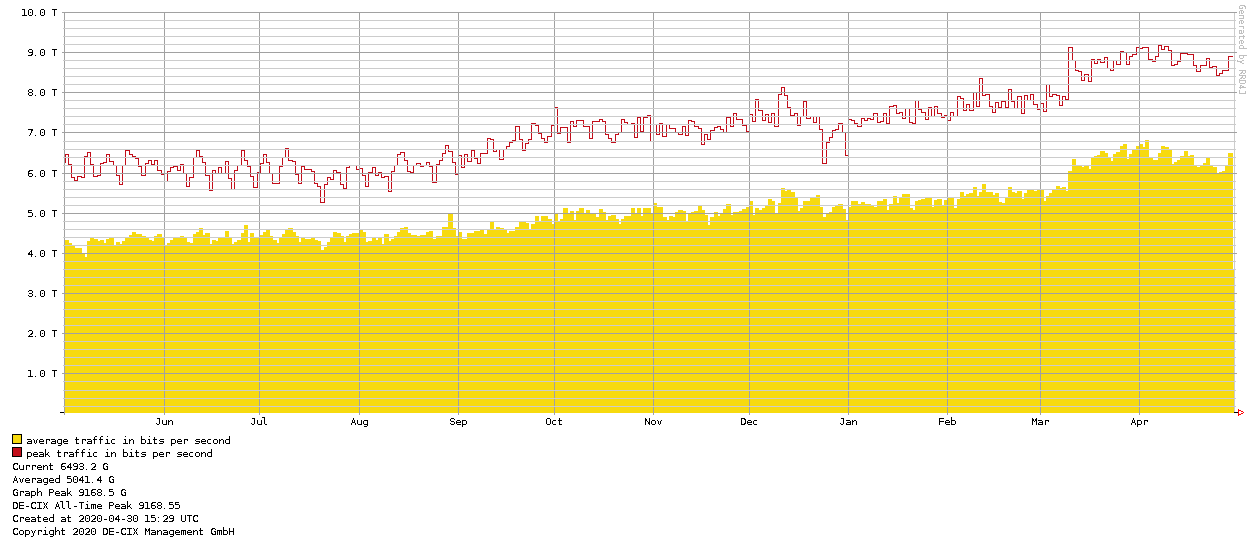

In [130]:
img_file = 'traffic_FRA-1year-1170-400.png'
img = Image.open(img_file)
display(img)

In [132]:
yellow = [247, 218, 15, 255]
red = [194, 14, 26, 255]
darkgrey = [161, 161, 161, 255]
lightgrey = [204, 204, 204, 255]

In [133]:
I = np.asarray(img)

yellow_cols = []
tick_cols = []

for i, col in enumerate(I.transpose(1, 0, 2)):
    greyPixelsInLine = 0
    isYellow = False
    isTick = False
    for pixel in col:
        if not isYellow and (pixel == yellow).all():
            yellow_cols.append(i)
            isYellow = True
        elif not isTick and ((pixel == darkgrey).all() or (pixel == lightgrey).all()):
            greyPixelsInLine += 1
            if greyPixelsInLine > 5:
                tick_cols.append(i)
                isTick = True
        else:
            greyPixelsInLine = 0
                
        if isYellow and isTick:
            break

In [134]:
tick_rows = []

for i, row in enumerate(I):
    greyPixelsInLine = 0
    for pixel in row:
        if (pixel == darkgrey).all():
            greyPixelsInLine += 1
            if greyPixelsInLine > 5:
                tick_rows.append(i)
                break
        else:
            greyPixelsInLine = 0

In [162]:
min_col = tick_rows[0]
max_col = tick_rows[-1]

min_col = tick_cols[0]
max_col = tick_cols[-1]

In [163]:
for i, pixel in enumerate(I.transpose(1, 0, 2)[yellow_cols[-1]], 0):
    if (pixel == yellow).all():
        max_value = i

In [164]:
values_average = []
values_peak = []

for col in range(min_col, max_col-1):
    if col in yellow_cols:
        foundPeak = False
        foundAverage = False
        for row, pixel in enumerate(I.transpose(1, 0, 2)[col]):
            if (pixel == yellow).all() and not foundAverage:
                values_average.append(row)
                foundAverage = True
            if (pixel == red).all() and not foundPeak:
                values_peak.append(row)
                foundPeak = True
        if not foundPeak:
            values_peak.append(None)
    else:
        values_average.append(None)
        values_peak.append(None)

In [165]:
y_scale_max = 10

def normalize(val):
    if val is None:
        return val
    else:
        return y_scale_max * (1 - (val - min_col) / (max_col - min_col))
                          
values_average = list(map(normalize, values_average))
values_peak = list(map(normalize, values_peak))

In [166]:
end_datetime = datetime(2020, 5, 1)
start_datetime = end_datetime.replace(year = end_datetime.year - 1)

In [167]:
df_traffic = pd.DataFrame({'Average': values_average, 'Peak': values_peak}, index = pd.date_range(start=start_datetime, end=end_datetime, periods=len(values_average)))
df_traffic.interpolate(limit_direction='both', inplace=True)

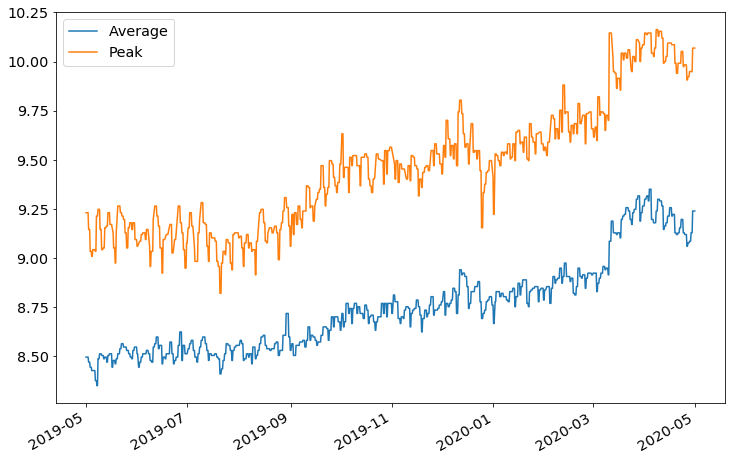

In [168]:
df_traffic.plot()

In [158]:
df_traffic.to_csv('traffic_frankfurt_year' + end_datetime.strftime("%Y%m") + '.csv')

In [159]:
df_traffic['Average'] = df_traffic['Average'].rolling(30).mean().interpolate(limit_direction='both')
df_traffic.index.name = 'Date'
df_traffic.reset_index(level=0, inplace=True)

In [160]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

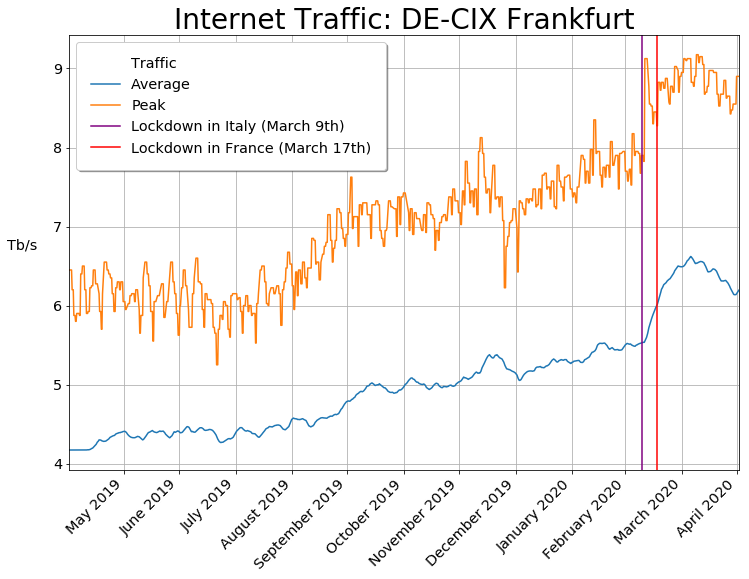

In [161]:
plt.title('Internet Traffic: DE-CIX Frankfurt', fontsize=28)
g = sns.lineplot(x='Date', y='Tb/s',hue='Traffic', data=pd.melt(df_traffic[['Date', 'Average', 'Peak']], ['Date'], var_name='Traffic', value_name='Tb/s'))
#plt.axvline(datetime(2020, 2, 14), color='purple', label='First coronavirus death in europe (Feb 14th)')
plt.axvline(datetime(2020, 3, 9), color='purple', label='Lockdown in Italy (March 9th)')
plt.axvline(datetime(2020, 3, 17), color='red', label='Lockdown in France (March 17th)')
#plt.axvline(datetime(2020, 4, 3), color='red', label='Exit restrictions in Germany (April 3rd)')
g.set_xlim(start_datetime, end_datetime)
g.grid(True)
g.set_xticks(pd.date_range(start=start_datetime, periods=12, freq='M'))
g.set_xticklabels(pd.date_range(start=start_datetime, periods=13, freq='M').strftime('%B %Y'), rotation=45, horizontalalignment='right')
g.xaxis.label.set_visible(False)
g.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
g.yaxis.set_label_coords(-0.07,0.5)
plt.ylabel('Tb/s').set_rotation(0)
plt.savefig('traffic_frankfurt_year' + start_datetime.strftime("%Y%m") + '.png', bbox_inches = "tight")